<a href="https://colab.research.google.com/github/carlosramos1/practicas-machine-learning/blob/main/SVM_implementacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
#importar librerias
import numpy as np
from cvxopt import matrix, solvers
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [70]:
# para comparar con mi implementación
from sklearn import svm

# Support Vector Machine

## Problema dual SVM

El problema de minimización esta dado por:

$$
\DeclareMathOperator*{\argmin}{argmin}
\argmin_ \alpha \quad
L(\alpha) = \frac{1}{2}\alpha^T \mathbf H\alpha - \mathbf 1^T \alpha \\
\text{sujeto a: } 0 \leq \alpha \leq C, \quad y^T \alpha = 0
$$

In [71]:
# minimización del problema dual
def min_dual_problem(X, y, C, kernel, gamma=0.5, d=2):
  n = X.shape[0]
  y = y.reshape((1,n)) # conversión a array 2D

  K = kernel_matrix(X, X, kernel, gamma, d)
  H = (y.T @ y) * K

  # Conversión a formato cvxopt
  P = matrix(H)
  q = matrix(-np.ones((n, 1)))
  G = matrix(np.vstack([-np.eye(n), np.eye(n)]))
  h = matrix(np.vstack([np.zeros((n, 1)), C * np.ones((n, 1))]))
  A = matrix(y)
  b = matrix(0.0)

  solvers.options['show_progress'] = False
  solution = solvers.qp(P, q, G, h, A, b)

  # retornar alphas encontrados
  return np.array(solution['x']).flatten()

In [72]:
def kernel_matrix(X1, X2, kernel_type, gamma=0.5, d=2):
  K = np.zeros((X1.shape[0], X2.shape[0]))

  if kernel_type == "linear":
      for i, xi in enumerate(X1):
          for j, xm in enumerate(X2):
              K[i, j] = np.dot(xi, xm)

  elif kernel_type == "radial":
      for i, xi in enumerate(X1):
          for j, xm in enumerate(X2):
              K[i, j] = np.exp(-gamma * np.linalg.norm(xi - xm) ** 2)

  elif kernel_type == "poly":
      for i, xi in enumerate(X1):
          for j, xm in enumerate(X2):
              K[i, j] = (1 + np.dot(xi, xm)) ** d
  return K

## Modelo con kernel lineal

### Parametros $\mathbf w$ y $b$ y función de predicción

$$
\mathbf w=\mathbf{X^\intercal \alpha y} 		\\
b=(\mathbf y-\mathbf{Xw})_{\in S}
$$

In [73]:
def get_w_b(alphas, X, y, C):

  # Los support vectors son 0 < alphas < C
  support = (alphas > 1e-5) & (alphas < C - 1e-5)

  w = X.T @ (alphas * y)
  b = y[support] - (X[support] @ w)
  b = np.mean(b)
  return w, b, support

$$
\hat y = \operatorname{sign}(\mathbf w^T \mathbf x_i + b)
$$

In [74]:
# predecir
def predict_linear_kernel(X, w, b):
  return np.sign(X @ w + b)

### Datos de prueba

Vamos a crear datos de juguete para un modelo con un kernel lineal

In [75]:
# Datos de juguete
n = 1000

np.random.seed(8888)

X = np.random.rand(n, 2)
y = np.zeros((n,))

noise = np.random.uniform(-0.05, 0.05, n)

for i in range(n):
  x1 = X[i][0]
  x2 = X[i][1] + noise[i]
  y[i] = 1.0 if x2 <= 1.0 * x1 else -1.0

X

array([[0.96238432, 0.69422036],
       [0.44226615, 0.02448785],
       [0.07069067, 0.7940371 ],
       ...,
       [0.844407  , 0.54356138],
       [0.74869692, 0.20513935],
       [0.05775425, 0.95214338]])

In [76]:
y[:20]

array([ 1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1.,
       -1., -1.,  1., -1., -1., -1.,  1.])

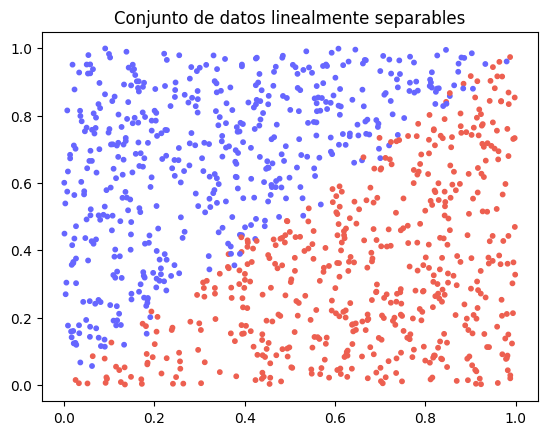

In [77]:
# Graficando los puntos
colors = ["#6666ff" if val == -1 else "#ed5f50" for val in y]

plt.scatter(X[:,0],
            X[:,1],
            c=colors,
            s=10)

plt.title("Conjunto de datos linealmente separables")
plt.show()

### Entrenamiento y predicción del modelo

In [78]:
# entrenar el modelo
C = 10.0  # parámetro de regularización
alphas = min_dual_problem(X, y, C, kernel="linear")
w, b, S = get_w_b(alphas, X, y, C)
print('Support vectors: ', X[S])
print('w: ', w)
print('b: ', b)

Support vectors:  [[0.38837878 0.34038115]
 [0.17717234 0.25944888]
 [0.10950553 0.19124184]
 [0.41570982 0.36535005]
 [0.20481103 0.15846588]
 [0.59524125 0.54297686]
 [0.05181929 0.00467739]
 [0.97040613 0.91614136]
 [0.84291443 0.78972575]
 [0.46867137 0.41533734]
 [0.72164826 0.67036201]
 [0.72778174 0.80392777]
 [0.69636169 0.77613713]
 [0.66911047 0.74598664]
 [0.80996419 0.88797609]
 [0.3107712  0.26232361]]
w:  [ 15.27470173 -15.37652321]
b:  0.27328437681903894


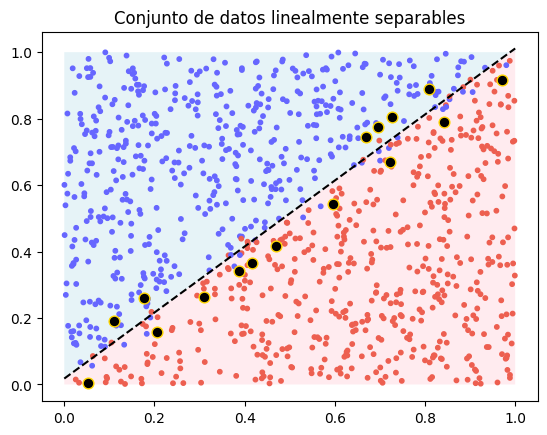

In [79]:
# Graficar los vectores de soporte

# Eje continuo
U = np.linspace(0, 1, 200)
V = -w[0] * U / w[1] - b / w[1]
plt.plot(U, V, 'k--')

# Fondo
plt.fill_between(U, V, 1, facecolor="lightblue", alpha=0.3)       # arriba
plt.fill_between(U, V, 0, facecolor="pink", alpha=0.3)  # abajo


colors = ["#6666ff" if val == -1 else "#ed5f50" for val in y]
plt.scatter(X[:,0],
            X[:,1],
            c=colors,
            s=10)
sv = X[S]
plt.scatter(sv[:,0],
            sv[:,1],
            c="black",
            s=60,  edgecolors="gold")


plt.title("Conjunto de datos linealmente separables")
plt.show()

In [80]:
# predecir para los mismos datos
y_hat = predict_linear_kernel(X, w, b)
y_hat[:20]

array([ 1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1.,
       -1., -1.,  1., -1., -1., -1.,  1.])

In [81]:
# Matriz de confusión
cm = confusion_matrix(y_hat, y)
print(cm)

[[477  10]
 [ 20 493]]


In [82]:
# Medida de aciertos
(cm[0,0]+cm[1,1])/y.size

np.float64(0.97)

### Comparación con la librería `sklearn`

In [83]:
# Definición del modelo
svm_model = svm.SVC(C=C, kernel='linear')

# Entrenamiento
svm_model.fit(X, np.ravel(y))

SVC(C=10.0, kernel='linear')

In [84]:
print('Support vectors: ', svm_model.support_vectors_)
print('w: ', svm_model.coef_)
print('b: ', svm_model.intercept_)

Support vectors:  [[0.69513335 0.7663747 ]
 [0.38941598 0.44601498]
 [0.7004072  0.67370027]
 [0.52824076 0.55465161]
 [0.52347417 0.58781318]
 [0.11535862 0.1771334 ]
 [0.93311468 0.95335095]
 [0.4444861  0.47152864]
 [0.82614969 0.88019558]
 [0.10950553 0.19124184]
 [0.42337491 0.43378333]
 [0.83004576 0.88119664]
 [0.36330917 0.41988394]
 [0.83981597 0.82848615]
 [0.18476051 0.25463255]
 [0.73928658 0.74277956]
 [0.47620432 0.4992582 ]
 [0.03594811 0.06695128]
 [0.18451979 0.2439738 ]
 [0.11753524 0.19207583]
 [0.40084045 0.46844744]
 [0.3692198  0.41143946]
 [0.08153892 0.11563689]
 [0.06184201 0.0564155 ]
 [0.09022282 0.11379492]
 [0.71996467 0.71161967]
 [0.82234024 0.83468244]
 [0.07655406 0.14054159]
 [0.4141239  0.47512233]
 [0.1855216  0.25846542]
 [0.37726724 0.35543892]
 [0.88412919 0.88076375]
 [0.42509249 0.49337941]
 [0.49158404 0.55427759]
 [0.69752396 0.70170585]
 [0.55596764 0.62070429]
 [0.64249374 0.6601817 ]
 [0.65998572 0.66735011]
 [0.8236104  0.87069776]
 [0.369

In [85]:
# Predicción y Matriz de confución
cm_svm = confusion_matrix(y, svm_model.predict(X))
cm_svm

array([[477,  20],
       [ 11, 492]])

El resultado de `sklearn.svm` es muy similar a la implementación.

## Kernel de Base Radial (RBF)

### Parámetro $b$ y función de estimación

Se calcula mediante:

$$
b = (y_i - \sum_{m=1}^n \alpha_m y_m k(x_i, x_m))_ \mathbb S
$$

- $\mathbb S$ es un subconjunto conformado por los *support vectors*: $(\mathbf x_i,y_i) \in \mathbb S$. Recordar que los *support vectors* son los puntos con $0<\alpha_i<C$.

$$
f(x_j) = \sum_{i=1}^n \alpha_i y_i k(x_j, x_i)+b
$$

In [86]:
def get_b_rbf(alphas, X, y, C, gamma):
  # Los support vectors son 0 < alphas < C
  support = (alphas > 1e-5) & (alphas < C - 1e-5)

  b = y[support] - np.sum(alphas * y * kernel_matrix(X[support], X, "radial", gamma=gamma), axis=1)
  b = np.mean(b)

  return b, support

In [87]:
def predict_rbf(X_new, X, y, b, alphas, gamma):
    f_x = np.sum(alphas * y * kernel_matrix(X_new, X, "radial", gamma=gamma), axis=1) + b
    return np.sign(f_x)

### Datos de prueba

In [88]:
# Datos de juguete dataset para un kernel de base radial
n = 1000

np.random.seed(8888)
noise = np.random.uniform(-0.05, 0.05, n)

X_r = np.random.rand(n, 2)
y_r = np.zeros((n,))
r = 0.3
centre = np.array([0.5, 0.5])

for i in range(n):
    dist = np.linalg.norm(X_r[i] - centre) + noise[i]
    y_r[i] = 1.0 if dist <= r else -1.0

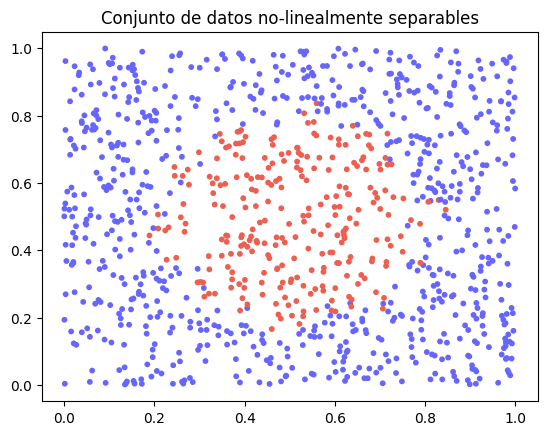

In [89]:
# Graficar los datos
colors = ["#6666ff" if val == -1 else "#ed5f50" for val in y_r]
plt.scatter(X_r[:,0],
            X_r[:,1],
            c=colors,
            s=10)

plt.title("Conjunto de datos no-linealmente separables")
plt.show()

### Entrenamiento y predicción

In [90]:
# entrenar el modelo
C = 10.0  # parámetro de regularización
gamma = 0.5
alphas_r = min_dual_problem(X_r, y_r, C, "radial", gamma=gamma)
b_r, S_r = get_b_rbf(alphas_r, X_r, y_r, C, gamma)

In [91]:
#print('Alphas: ', alphas_r[S_r])
print('Support vectors: ',  X_r[S_r])
print('b: ', b_r)

Support vectors:  [[0.67855692 0.58614891]
 [0.66809438 0.16317127]
 [0.36935331 0.15339404]
 [0.57105218 0.85236529]
 [0.22646597 0.28086238]
 [0.82923342 0.59919096]
 [0.14646537 0.55098912]
 [0.36284968 0.35065891]
 [0.64048245 0.15926322]
 [0.64644234 0.16362548]
 [0.20495951 0.31583294]
 [0.40058025 0.31221978]
 [0.69379921 0.55601505]
 [0.39818195 0.15315512]
 [0.35979368 0.83672573]
 [0.48487993 0.85842382]
 [0.84298708 0.57425214]
 [0.7948963  0.2776459 ]
 [0.81889585 0.32585975]
 [0.14865558 0.48393822]
 [0.6855508  0.54179823]
 [0.3383995  0.61396559]
 [0.85140277 0.49453963]
 [0.69208104 0.43056219]
 [0.43868218 0.13363558]
 [0.55501237 0.85113977]
 [0.19726434 0.33309003]
 [0.844407   0.54356138]
 [0.34255663 0.1732027 ]
 [0.67802939 0.81017322]
 [0.83857309 0.59033601]
 [0.81652694 0.32726117]
 [0.59285931 0.1447563 ]
 [0.41266214 0.85674469]
 [0.54042014 0.85512508]
 [0.39506491 0.67392868]
 [0.6218242  0.83191333]
 [0.41961394 0.84987544]
 [0.5945424  0.67591009]
 [0.145

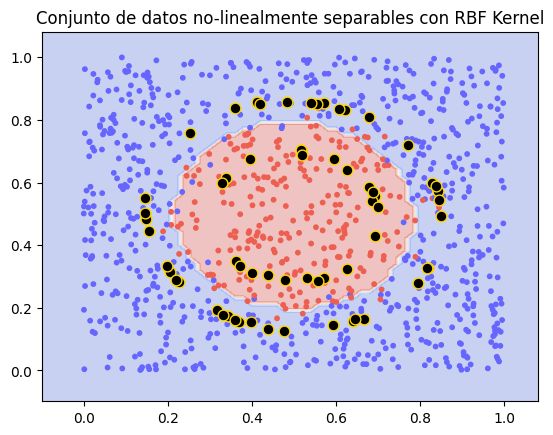

In [92]:
# Graficar los vectores de soporte
# Create a meshgrid to plot the decision boundary
h = .02  # step size in the mesh
x_min, x_max = X_r[:, 0].min() - .1, X_r[:, 0].max() + .1
y_min, y_max = X_r[:, 1].min() - .1, X_r[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Predict the class for each point in the meshgrid
Z = predict_rbf(np.c_[xx.ravel(), yy.ravel()], X_r, y_r, b_r, alphas_r, gamma)
Z = Z.reshape(xx.shape)

# Plot the decision boundary and the data points
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.3)

# Plot the data points
colors = ["#6666ff" if val == -1 else "#ed5f50" for val in y_r]
plt.scatter(X_r[:,0],
            X_r[:,1],
            c=colors,
            s=10)

# Plot the support vectors
sv = X_r[S_r]
plt.scatter(sv[:,0],
            sv[:,1],
            c="black",
            s=60,  edgecolors="gold")

plt.title("Conjunto de datos no-linealmente separables con RBF Kernel")
plt.show()

In [93]:
# predecir para los mismos datos
y_hat = predict_rbf(X_r, X_r, y_r, b_r, alphas_r, gamma)
y_hat[:20]

array([-1., -1., -1., -1., -1.,  1., -1.,  1., -1.,  1., -1., -1., -1.,
       -1., -1., -1.,  1., -1., -1., -1.])

In [94]:
# Matriz de confusión
cm = confusion_matrix(y_r, y_hat)
print(cm)

[[726  14]
 [ 23 237]]


In [95]:
# Medida de aciertos
(cm[0,0]+cm[1,1])/y_r.size

np.float64(0.963)

### Comparacion con la libreria sklearn

In [96]:
# Definición del modelo
svm_model = svm.SVC(C=10, kernel='rbf', gamma=0.5)

# Entrenamiento
svm_model.fit(X_r, np.ravel(y_r))

SVC(C=10, gamma=0.5)

In [97]:
svm_model.intercept_

array([-22.95559056])

In [98]:
#svm_model.coef_  #error: coef_ is only available when using a linear kernel

In [99]:
# Predicción y Matriz de confución
cm_svm = confusion_matrix(y_r, svm_model.predict(X_r))
cm_svm

array([[726,  14],
       [ 23, 237]])

El resultado de `sklearn.svm` es muy similar a la implementación.

## Kernel de Base Polinómico

### Parámetro $b$ y función de estimación

Se calcula mediante:

$$
b = (y_i - \sum_{m=1}^n \alpha_m y_m k(x_i, x_m))_ \mathbb S
$$

- $\mathbb S$ es un subconjunto conformado por los *support vectors*: $(\mathbf x_i,y_i) \in \mathbb S$. Recordar que los *support vectors* son los puntos con $0<\alpha_i<C$.

$$
f(x_j) = \sum_{i=1}^n \alpha_i y_i k(x_j, x_i)+b
$$

In [100]:
def get_b_poly(alphas, X, y, C, d):
  # Los support vectors son 0 < alphas < C
  support = (alphas > 1e-5) & (alphas < C - 1e-5)

  b = y[support] - np.sum(alphas * y * kernel_matrix(X[support], X, "poly", d=d), axis=1)
  b = np.mean(b)

  return b, support

In [101]:
def predict_poly(X_new, X, y, b, alphas, d):
    f_x = np.sum(alphas * y * kernel_matrix(X_new, X, "poly", d=d), axis=1) + b
    return np.sign(f_x)

### Datos de prueba

In [102]:
# Datos de juguete dataset para un kernel de base radial
n = 1000

np.random.seed(8888)
noise = np.random.uniform(-0.5, 0.5, n)

X_p = np.random.rand(n, 2) * 4 - 2
y_p = np.zeros((n,))

for i in range(n):
  if X_p[i, 1] > X_p[i, 0]**3 - noise[i]:  #y = x^3
    y_p[i] = -1
  else:
    y_p[i] = 1

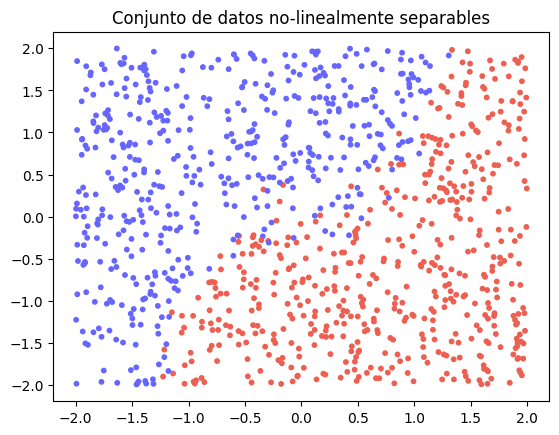

In [103]:
# Graficar los datos
colors = ["#6666ff" if val == -1 else "#ed5f50" for val in y_p]
plt.scatter(X_p[:,0],
            X_p[:,1],
            c=colors,
            s=10)

plt.title("Conjunto de datos no-linealmente separables")
plt.show()

### Entrenamiento y predicción

In [123]:
# entrenar el modelo
C = 10.0  # parámetro de regularización
d = 3
alphas_p = min_dual_problem(X_p, y_p, C, "poly", d=d)
b_p, S_p = get_b_poly(alphas_p, X_p, y_p, C, d)

In [124]:
#print('Alphas: ', alphas_p)
print('Support vectors: ',  X_p[S_p])
print('b: ', b_p)

Support vectors:  [[-1.26287648 -1.75477918]
 [-1.13715603 -1.86309759]
 [ 0.47967142 -0.17260553]
 [ 0.41179855  0.24378461]
 [ 0.48998844 -1.95137717]
 [-0.40518228 -0.32743211]
 [-1.06079165 -1.37692997]
 [ 1.07618694  0.95806659]
 [ 1.33478622  1.98118451]]
b:  -0.27807652026597096


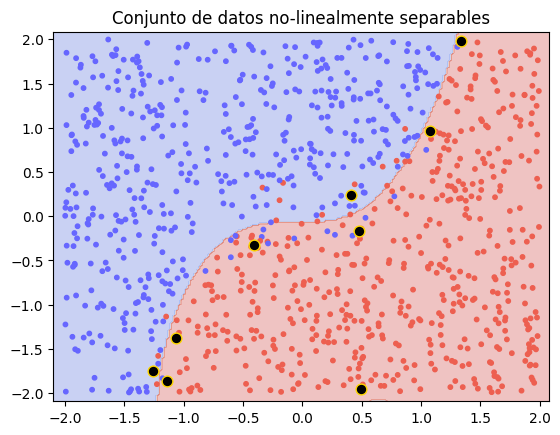

In [125]:
# Graficar los vectores de soporte
# Create a meshgrid to plot the decision boundary
h = .02  # step size in the mesh
x_min, x_max = X_p[:, 0].min() - .1, X_p[:, 0].max() + .1
y_min, y_max = X_p[:, 1].min() - .1, X_p[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Predict the class for each point in the meshgrid
Z = predict_poly(np.c_[xx.ravel(), yy.ravel()], X_p, y_p, b_p, alphas_p, d)
Z = Z.reshape(xx.shape)

# Plot the decision boundary and the data points
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.3)

# Plot the data points
colors = ["#6666ff" if val == -1 else "#ed5f50" for val in y_p]
plt.scatter(X_p[:,0],
            X_p[:,1],
            c=colors,
            s=10)

# Plot the support vectors
sv = X_p[S_p]
plt.scatter(sv[:,0],
            sv[:,1],
            c="black",
            s=60,  edgecolors="gold")

plt.title("Conjunto de datos no-linealmente separables")
plt.show()

In [126]:
# predecir para los mismos datos
y_hat = predict_poly(X_p, X_p, y_p, b_p, alphas_p, d)
y_hat[:20]

array([ 1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1.,  1.,  1., -1., -1.,
       -1., -1.,  1.,  1.,  1., -1., -1.])

In [127]:
# Matriz de confusión
cm = confusion_matrix(y_p, y_hat)
print(cm)

[[469  16]
 [ 16 499]]


In [128]:
# Medida de aciertos
(cm[0,0]+cm[1,1])/y_p.size

np.float64(0.968)

### Comparacion con la libreria sklearn

In [129]:
# Definición del modelo
svm_model = svm.SVC(C=C, kernel='poly', degree=d, coef0=1, gamma=1)

# Entrenamiento
svm_model.fit(X_p, np.ravel(y_p))

SVC(C=10.0, coef0=1, gamma=1, kernel='poly')

In [121]:
svm_model.intercept_

array([0.2419754])

In [112]:
#svm_model.coef_  #error: coef_ is only available when using a linear kernel

In [130]:
# Predicción y Matriz de confución
yp_hat = svm_model.predict(X_p)
cm_svm = confusion_matrix(y_p, yp_hat)
cm_svm

array([[469,  16],
       [ 16, 499]])

Los resultados son muy similares

**Observaciones**:
- La implementación manual tiene la restriccion de $0<\alpha<C$ en cambio en la `sklearn` implementa $0<\alpha$ es por eso que varia en la cantidad de *support vectors*.
- Los parámetros $b$ y $w$ calculados manualemente y los obtenidos de `sklearn.svm` son muy similares.
- Tanto la implementación como la de `sklearn.svm` tiene la misma cantidad de aciertos y fracasos en la clasificación (se hizo la comparación mediante la matriz de confusión).
- Para el caso de un kernel polinómico, la implementación de `sklearn.svm` tiene una leve variación respecto al de la implementación:
  - *sklearn* lo plantea como: $k(\mathbf x_i, \mathbf x_m) = (\gamma(\mathbf x_i \cdot \mathbf x_m) + r )^d$ https://scikit-learn.org/stable/modules/svm.html#kernel-functions
  - en cambio el la implementación manual: $k(\mathbf x_i, \mathbf x_m) = (1+ (\mathbf x_i \cdot \mathbf x_m) )^d$

  